# Import Libraries

In [1]:
# data manipulation
import pandas as pd

# numpy arrays
import numpy as np

# data visualization
import seaborn as sns

import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set()

# NLP
import string

from wordcloud import WordCloud

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from vectorizers.NLTKVectorizer import NLTKVectorizer

import re

# machine learning
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.naive_bayes import MultinomialNB           # Naive Bayes
from sklearn.svm import LinearSVC                       # SVM
from sklearn.ensemble import RandomForestClassifier     # Random Forest

from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.calibration import CalibratedClassifierCV

# TODO:
# install the latest version of `sklearn` to use `plot_confusion_matrix` 
# from sklearn.metrics import plot_confusion_matrix

# Model explainability
import shap
from lime.lime_text import LimeTextExplainer

# other
from pprint import pprint
from time import time
import logging
from functools import partial
import joblib

# Helper Functions

This function is used to create a *palette* of `n` colors of `palette_name` colors.

In [2]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

This function is used to export the HTML of plotly `fig_obj`, and save it in: `assets/file_name.html`

In [3]:
def save_fig_as_div(fig_obj, file_name):
    with open(f'assets/{file_name}', 'w') as fig_file:
        fig_div_string = plotly.offline.plot(figure_or_data=fig_obj, output_type='div',
                                             include_plotlyjs='cdn')
        fig_file.write(fig_div_string)

# Load and Prepare Data

In [4]:
newsgroups_data = fetch_20newsgroups(subset='all')

In [5]:
categories = newsgroups_data.target_names

In [6]:
df = pd.DataFrame(data={
    'text': newsgroups_data.data,
    'category': newsgroups_data.target
})

In [7]:
df['category'] = df['category'].apply(lambda x: categories[x])

In [8]:
df.head()

,text,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware


In [9]:
df.shape

(18846, 2)

The dataset consists of 18,846 samples

# What is this Data?

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (e.g `misc.forsale` / `soc.religion.christian`).

Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

<table style='font-family:"Courier New", Courier, monospace; font-size:80%'>
    <tr>
        <td>comp.graphics<br>comp.os.ms-windows.misc<br>comp.sys.ibm.pc.hardware<br>comp.sys.mac.hardware<br>comp.windows.x
        </td>
        <td>rec.autos<br>rec.motorcycles<br>rec.sport.baseball<br>rec.sport.hockey</td>
        <td>sci.crypt<br>sci.electronics<br>sci.med<br>sci.space</td>
    </tr>
    <tr>
        <td>misc.forsale</td>
        <td>talk.politics.misc<br>talk.politics.guns<br>talk.politics.mideast</td>
        <td>talk.religion.misc<br>alt.atheism<br>soc.religion.christian</td>
    </tr>
</table>

# Data Statistics

One quick *data-cleaning* step is to rename the category columns to something more readable:

In [10]:
df = df.assign(category=df['category'].apply(lambda x: '_'.join(x.split('.')[1:])))

In [11]:
df['category'].unique()

array(['sport_hockey', 'sys_ibm_pc_hardware', 'politics_mideast',
       'sys_mac_hardware', 'electronics', 'religion_misc', 'crypt', 'med',
       'atheism', 'motorcycles', 'autos', 'windows_x', 'graphics',
       'space', 'politics_guns', 'forsale', 'sport_baseball',
       'politics_misc', 'os_ms-windows_misc', 'religion_christian'],
      dtype=object)

Calculate for each category in the dataset the number of articles, the average article length, the max article length, and the min article length

In [12]:
categories_statistics_df = df.groupby(by='category')['text'].agg({
                                'count': lambda x: x.size,
                                'mean': lambda x: x.str.len().mean(),
                                'max': lambda x: x.str.len().max(),
                                'min': lambda x: x.str.len().min()
                            })\
                            .reset_index()\
                            .sort_values(by='count', ascending=False)

using a dict on a Series for aggregation
is deprecated and will be removed in a future version


## Categories article count:

Use a pie chart to the percentages of articles for each category:

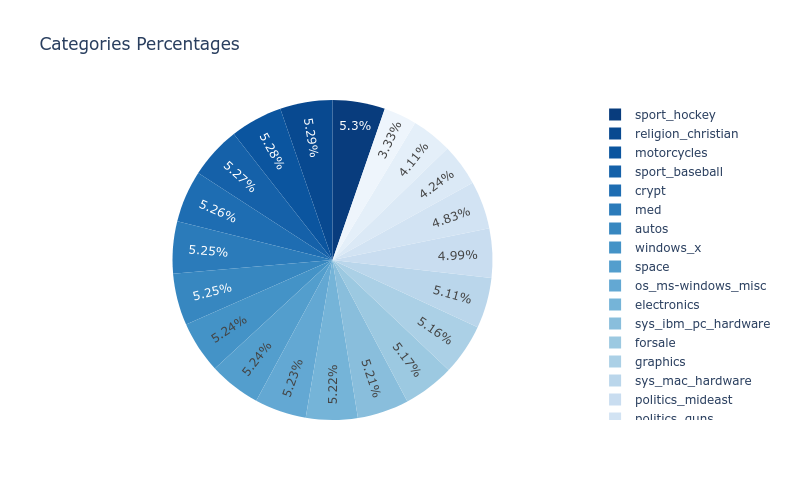

In [13]:
blue_palette = get_n_color_palette('Blues', 20, True)

fig = px.pie(data_frame=categories_statistics_df, names='category', values='count',
            color_discrete_sequence=blue_palette, title='Categories Percentages',
            width=800, height=500)

fig.show()

We can see that the dataset is *balanced*

In [14]:
save_fig_as_div(fig, file_name='categories-percentages-pie-chart.html')

## Categories average article length:

Use a bar chart to show the average article length per category:

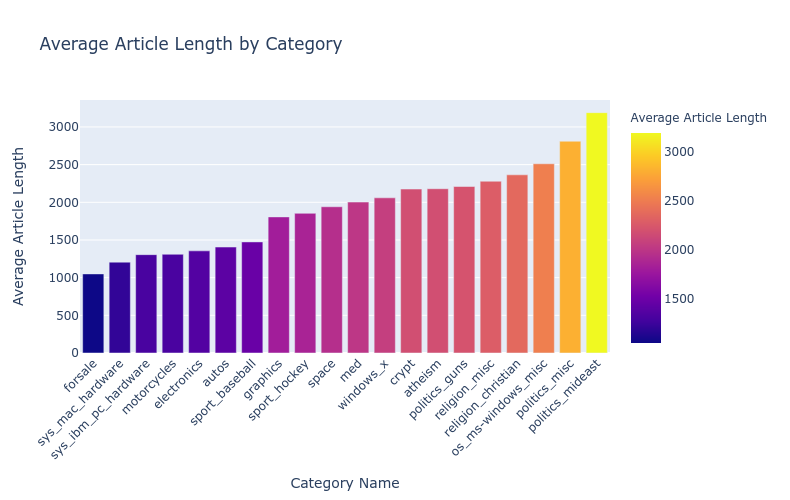

In [16]:
chart_labels = {
    'mean': 'Average Article Length',
    'category': 'Category Name'
}

fig = px.bar(data_frame=categories_statistics_df.sort_values(by='mean'),
             x='category', y='mean', color='mean', labels=chart_labels,
             title='Average Article Length by Category',
             width=800, height=500)

# rotate x-axis ticks
fig.update_xaxes(tickangle=-45)

fig.show()

This chart shows how lengthy the *polictics* articles, compared to *computer* articles

In [17]:
save_fig_as_div(fig, file_name='average-article-length-bar-chart.html')

# Word Cloud

In [ ]:
en_stop_words = list(set(stopwords.words('english')))

In [ ]:
categories_text_df = df.groupby(by='category')\
                        .agg({
                            'text': ' '.join
                        })\
                        .reset_index()

In [ ]:
categories_text_df

In [ ]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize=(8, 8))
    wc = WordCloud(background_color="white", stopwords=en_stop_words, width=1000, height=600)
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

The following word clouds will help us to take a glimpse on the data, and its content.

Each word cloud shows the relative frequency of words in a category, words with higher *frequencies* have bigger *size*.

This will help us to see what are the **dominant** words in each category.

In [ ]:
for idx, row in categories_text_df.iterrows():
    plot_word_cloud(row['category'], row['text'])

# Split the data

Split the data into 75% training and 25% testing, with stratified sampling, to make sure that the class labels percentages in both training and testing data is (nearly) equal.

In [ ]:
X = df['text']
y = df['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Text Vectorization

In this step, we'll build a **text vectorization** transformer which will be used to convert the raw text documents into appropriate features, prepared to be input for the machine learning algorithms.

**Note**: disabling the *parser* and the *named entity recognizer* components, make the processing of the document much more efficient, and it's advised according to the [Documentation](https://spacy.io/usage/processing-pipelines#disabling) 

I will define a *custom vectorizer* called `SpacyVectorizer`. This vectorizer inherits and the `TfidfVectorizer` and overrides the `build_analyzer` method. The resulting vectorizer will have the same parameters as the `TfidfVectorizer` but it will *analyze* the documents in a different manner, mainly it will `spaCy` tokenzier, and then will keep only clean tokens.

Use `NLTKVectorizer`

# Create Pipeline

Use a very minimalistic Pipeline consisting of only two stpes:
- Text Vectorizer (Transformer): in this step the vectorizer takes the raw text input, perform some data cleaning, text representation (using TF-IDF), and returns an array of features for each sample in the dataset.
- Classifier (estimator): the classifier then takes the output produced by the previous step (which is features matrix), and use it as input to traing machine learning algorithm to learn from the data.

Why pipelines?

Pieplines are the recommended approach of combining data processing steps with machine learning stpes, they let use *seamlessly* apply many transformations on the input data, and finally train a model on the produced data.

They are considered as one of the best-practises in `sklearn`.

Here, we are creating a two-step pipeline, which may doesn't show how important it is, but it's very common to create a very complex pipline consisting of many data transformations steps followed by a machine learning model.

Another bonus of pieplines, is that they can help us perform cross validation on the data all at once, and tune the hyper-parameters.

There are many great resources about the importance of using pipelines, and how to use them:

- [Deploying Machine Learning using sklearn pipelines](https://www.youtube.com/watch?v=URdnFlZnlaE)
- [A Simple Example of Pipeline in Machine Learning with Scikit-learn](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)
- [A Deep Dive Into Sklearn Pipelines](https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines)

In [ ]:
# text vectorizer
vectorizer = TfidfVectorizer(stop_words=en_stop_words,
                             max_df=0.5, min_df=10, max_features=10000)

# Logistic Regression classifier
lr_clf = LogisticRegression(C=1.0, solver='newton-cg', multi_class='multinomial')

# Naive Bayes classifier
nb_clf = MultinomialNB(alpha=0.01)

# SVM classifier
svm_clf = LinearSVC(C=1.0)

# Random Forest classifier
random_forest_clf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                                           max_depth=50, random_state=0)

In [ ]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', lr_clf)
])

# Hyper-parameters tunning

**NOTE**: only run the following cells when you want to know the best parameters, once the best parameters are found, use them to create the piepline.

Choosing the right parameters of our text vectorizer and classifier is a troublesome, there are many parameters, we need to assign a value for each parameter, train the model, and see the accuracy of our model.

This trail-and-error approach could be summarized as the following:
- select one parameter of the hyper-parameters at a time.
- assign this parameter an appropriate value (depending on this parameter represent).
- train the model.
- compare the accuracy
- repeat for another parameter.

Luckily, `sklearn` supports tunning the hyper-parameters in a much nicer way using its `GridSearchCV` class, which performs **Exhaustive** search over the specified parameters settings, and beside searching for the best parameters, it optimize the results by cross validating the model, and reporting the average model across the splits.

`Sklearn` supports another approach for tuning the hyper-parameters, they are explaind in details in the [documentation](https://scikit-learn.org/stable/modules/grid_search.html) 

The parameter settings to tune:

In [ ]:
parameters = {
    # vectorizer hyper-parameters
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__max_df': [0.4, 0.5, 0.6],
    'vect__min_df': [10, 50, 100],
    'vect__max_features': [5000, 10000],
    # classifiers
    'clf': [lr_clf, nb_clf, svm_clf, random_forest_clf]
}

In [ ]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, refit=True)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs\n" % (time() - t0))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

## What are the best vectorizer and classifier params:

In [ ]:
grid_search.best_params_

Pipeline best params:

{'clf': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0),
'vect__max_df': 0.5,
'vect__max_features': 10000,
'vect__min_df': 10,
'vect__ngram_range': (1, 1)}

the best parameters reported after performing grid search:
- `clf`: the classifier which achieved the highest score is the `LinearSVC`.
- `max_df`: terms that have a document frequency higher than 50% are ignored.
- `min_df`: terms that have document frequency strictly lower than 10 are ignored.
- `ngram_range`: using only unigrams.
- `max_features`: selecting only 10,000 features.

## What is the best estimator:

In [ ]:
grid_search.best_estimator_

# Best classifier

Create a pipeline with the best parameters found by the grid search:

In [ ]:
vectorizer = NLTKVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 1),
                            max_features=10000, stop_words=en_stop_words)

svm_clf = LinearSVC(C=1.0)

The `LinearSVC` class, has only `predict` method, while other classifiers has the `predict_proba` method. Later on we'll need the `predict_proba` mthod for predicting probabilities for samples, to use it in explaining the model predictions.

One way to obtain the probabilities of the classifier is to wrap it in `CalibratedClassifierCV` class, after using this class we'll be able to use the `predict_proba` method.

Resources about how the `CalibratedClassifierCV` works, and how to use it:

- [Sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)
- [Converting LinearSVC's decision function to probabilities (Scikit learn python)](https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python/39712590#39712590)
- [Scikit correct way to calibrate classifiers with CalibratedClassifierCV](https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv/263411#263411)

In [ ]:
clf = CalibratedClassifierCV(base_estimator=svm_clf, cv=5, method='isotonic')

In [ ]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', clf)
])

Fit the pipeline on the training data, and then evaluate it on the test data.

In [ ]:
%%time
pipeline.fit(X_train, y_train)

In [ ]:
%%time
y_pred = pipeline.predict(X_test)

# Model Evaluation

## Classification report:

In [ ]:
clf_report = classification_report(y_true=y_test, y_pred=y_pred,
                                   target_names=pipeline.named_steps.clf.classes_,
                                   output_dict=True)

In [ ]:
clf_report_df = pd.DataFrame(data=clf_report)

In [ ]:
clf_report_df

In [ ]:
clf_report_df.drop(index='support', inplace=True)

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=clf_report_df.T, annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)
plt.show()

## Confusion matrix:

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test,
                     y_pred=y_pred,
                     labels=pipeline.named_steps.clf.classes_)

In [ ]:
conf_matrix_df = pd.DataFrame(data=conf_matrix, columns=pipeline.named_steps.clf.classes_,
                                index=pipeline.named_steps.clf.classes_)

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(data=conf_matrix_df, annot=True, cmap='RdPu', fmt='d')
plt.show()

# Model Explainability

At this point we should be done, right? after training the model and evaluating it, and achieving good results we should stop.

There are many unanswered questions so far, for example:
- How the model is working and making predictions (what are the features.
- When the model predicts coorectly and when it's not.
- Does the model generalize on the data.
- Debugging the model on certain predictions.

And most importantly, is this model reliable? can we use it in production with confidence?

We can think of our model more or less like a *Black Box*, it takes some input, and produce some output.

![alt text](assets/balck-box-ml.png "Black Box Machine Learning")

The field of *Explainable artificial intelligence* which is concerned with the tools and methods for explaining and interpreting machine learning algorithms, catched a large interest in the past few years, and there has been many libraries that can be used out of the box for interpreting machine learning and deep learning models:
- [eli5 (short for Explain like I'm 5)](https://github.com/TeamHG-Memex/eli5)
- [Lime: Explaining the predictions of any machine learning classifier](https://github.com/marcotcr/lime)
- [SHAP: A game theoretic approach to explain the output of any machine learning model](https://github.com/slundberg/shap)

These libraries differ in the way they work, and the type of models they can *interpret*

## Model complexity vs interpretability:

*Simple* linear models are easy to explain (since they consists of only linear equations), but their accuracy is low compared to *Complex* non-linear models, which achieve higher accuracy, but are harder to explain.

The following figure illustrates the relation between model accuracy and interpretability (Source: [The balance: Accuracy vs. Interpretability](https://towardsdatascience.com/the-balance-accuracy-vs-interpretability-1b3861408062)):

![alt text](assets/accuracy-vs-interpretability.png "Accuracy vs Interpretability")

Since we're using a *linear SVM* classifier, we'll try to visualize the weights assigned to the features, and see for each class (category) in our data, what are the features that affect the model's prediction positivly and negatively.

Resources about interpreting SVM classifier in `Sklearn`:
- [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights/39311#39311)
- [Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)

## Visualizing classifier weights:

In [ ]:
feature_names = pipeline['vect'].get_feature_names()

In [ ]:
clf = pipeline.named_steps['clf']

In [ ]:
coefs_values = sum([classifier.base_estimator.coef_ for classifier in clf.calibrated_classifiers_])

coefs_values = coefs_values / len(clf.calibrated_classifiers_)

In [ ]:
classes = clf.classes_

In [ ]:
n_feature = 15

In [ ]:
for i, class_label in enumerate(classes):

    # get indices of top positive/negative coefficient
    negative_coefs_indices = np.argsort(coefs_values[i])[:n_feature]
    positive_coefs_indices = np.argsort(coefs_values[i])[-n_feature:]

    # get the coefficient values
    negative_coefs = [coefs_values[i][coef_idx] for coef_idx in negative_coefs_indices]
    positive_coefs = [coefs_values[i][coef_idx] for coef_idx in positive_coefs_indices]

    # get the corresponding features names of the top coefficient
    negative_features = [feature_names[coef_idx] for coef_idx in negative_coefs_indices]
    positive_features = [feature_names[coef_idx] for coef_idx in positive_coefs_indices]

    # stack arrays into one array
    weights = np.concatenate([negative_coefs, positive_coefs])
    features = np.concatenate([negative_features, positive_features])

    # plot feature names agains their weight, using bar plot
    fig = px.bar(x=features, y=weights, color=weights, title=class_label)
    fig.show()
    
    # draw only for three features
    if i == 3:
        break

## Explaining individual predictions:

In [ ]:
clf_predictions_df = pd.DataFrame(data={'text': X_test.values,
                                        'real category': y_test.values,
                                        'predicted category': y_pred
                                       })

In [ ]:
clf_predictions_df.head()

In [ ]:
# samples which has been correctly classified
correct_classified_df = clf_predictions_df[
    clf_predictions_df['real category'] == clf_predictions_df['predicted category']
]

In [ ]:
# samples which has been incorrectly classified
incorrect_classified_df = clf_predictions_df[
    clf_predictions_df['real category'] != clf_predictions_df['predicted category']
]

In [ ]:
explainer = LimeTextExplainer(class_names=pipeline.classes_)

### When the model is performing well:

In [ ]:
correct_sample = correct_classified_df.sample()

In [ ]:
correct_sample

In [ ]:
exp_object = explainer.explain_instance(text_instance=correct_sample['text'].values[0],
                                       classifier_fn=pipeline.predict_proba, top_labels=2)

In [ ]:
exp_object.show_in_notebook()

### When the model is performing badly:

In [ ]:
incorrect_sample = incorrect_classified_df.sample()

In [ ]:
incorrect_sample

In [ ]:
exp_object = explainer.explain_instance(text_instance=incorrect_sample['text'].values[0],
                                       classifier_fn=pipeline.predict_proba, top_labels=2)

In [ ]:
exp_object.show_in_notebook()